In [7]:
import numpy as np
from sacla import *
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.signal as ss
import lmfit
from functools import *

In [2]:
run=saclarun('/UserData//gorkhover/TAIS2019/782530.h5',Tais2019)

In [32]:
def gethist(images,gain=None,**args):
    for img in images:
        if gain is not None:
            img=img*gain*3.65
        val,edge=np.histogram(img,**args)
        yield val

[ 6250. 12450. 18550.]


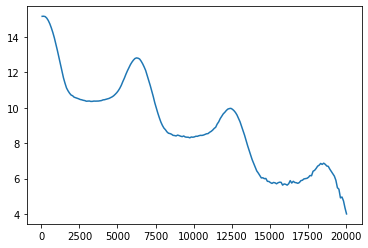

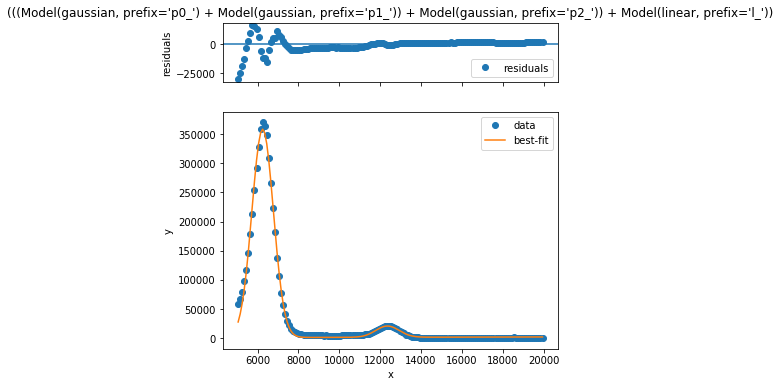

[ 6250. 12450. 18350.]


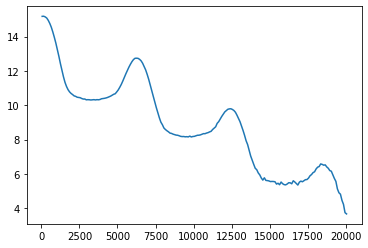

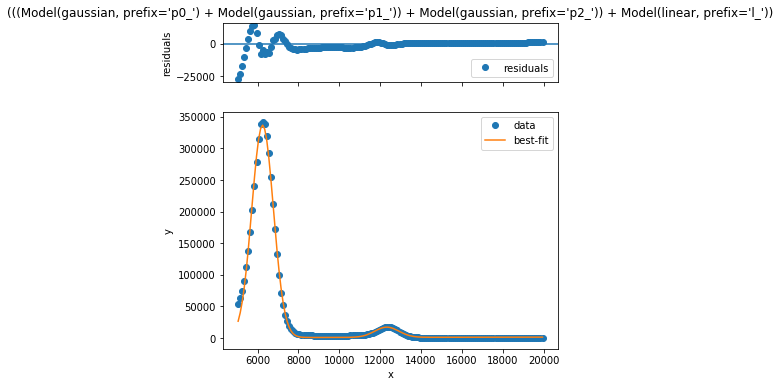

[ 6250. 12450. 18650.]


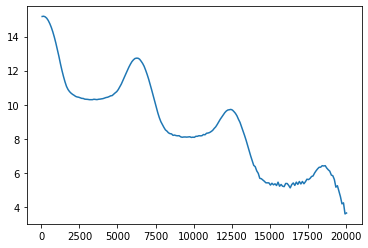

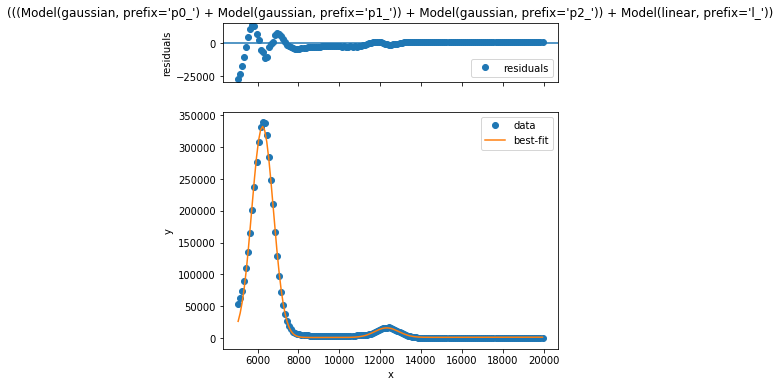

[ 6250. 12350. 18650.]


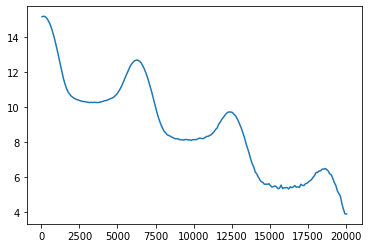

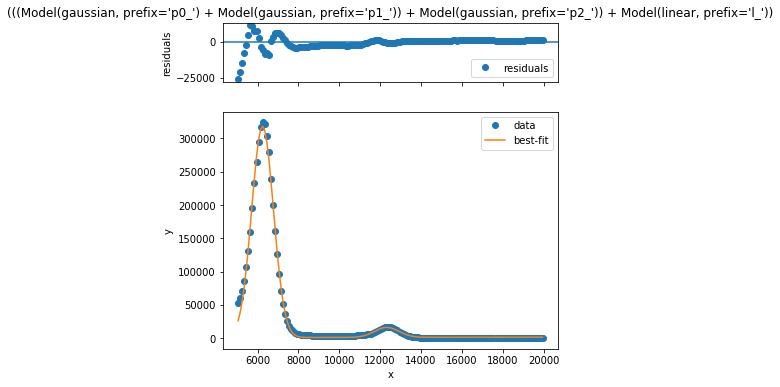

In [85]:
for i in range(1000,5000,1000):
    x=np.linspace(0,20000,201)+50
    hist=sum(gethist(run.detector_2d_3[i:i+100],gain=run.detector_2d_3.absolute_gain,range=[0,20000],bins=201))
    plt.plot(x,np.log(hist))
    centers,_=ss.find_peaks(np.log(hist),distance=20,prominence=1,width=1)
    centers=x[centers]
    print(centers)
    
    
    #centers=np.array([6400,2*6400])
    models=[]
    params=[]
    #gaussian peaks
    models=[lmfit.models.GaussianModel(prefix=f'p{i}_') for i in range(len(centers))]
    for i in range(len(centers)): models[i].set_param_hint(f'center', value=centers[i],min=centers[i]-250,max=centers[i]+250)
    for i in range(len(centers)): models[i].set_param_hint(f'amplitude', value=1e4,min=1e2,max=1e9)
    for i in range(len(centers)): models[i].set_param_hint(f'sigma', value=300,min=100,max=1e3)
    params=[m.make_params() for i,m in enumerate(models)]

    #linear background
    models.append(lmfit.models.LinearModel(prefix="l_"))
    models[-1].set_param_hint(f'slope', value=0)
    models[-1].set_param_hint(f'intercept', value=0,min=-500,max=500)
    params.append(models[-1].make_params()) 
    
    #combine
    model = reduce((lambda x, y: x + y), models)
    param=params[0]
    for p in params[1:]: param.update(p)


    output = model.fit(hist[50:-1], param, x=x[50:-1])
    output.plot()
    plt.show()

In [74]:
import numpy as np
from saclarun import saclarun
%matplotlib inline
import matplotlib.pyplot as plt
run=saclarun('/work/gorkhover/H5/TAIS2019/782510.h5')

In [89]:
count=0
accum=0

for img in run.detector_2d_3:
    dat=np.array(img)*run.detector_2d_3.absolute_gain*3.65
    seed=dat>2000
    empty=ss.convolve(seed,np.ones((5,5)),mode='same')<0.9
    count+=empty
    accum+=dat*empty
bg=accum/count

In [90]:
count=0
accum=0
for img in run.detector_2d_3:
    dat=np.array(img)*run.detector_2d_3.absolute_gain*3.65
    seed=dat>2000
    count+=seed
    accum+=seed*dat
mean=accum/count
gain=1/(mean/np.nanmean(mean))
#     ax.clear()

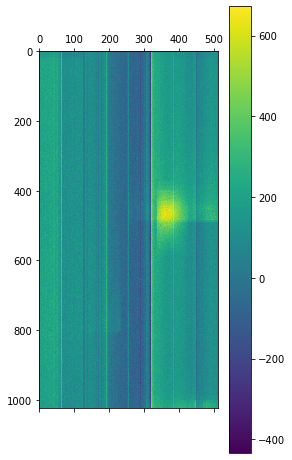

In [93]:
plt.matshow(bg)
plt.colorbar()


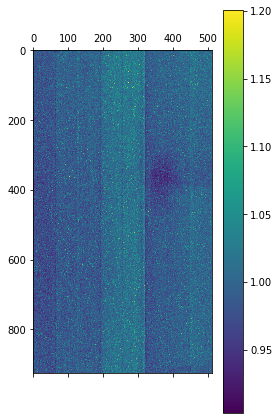

In [96]:
plt.matshow(gain[100:,...])
plt.colorbar()


/home/gorkhover/anaconda3/envs/zimmf/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


[6438.60833302109, 100.0]
[6438.60833302109, 100.0]
[6429.365844616144, 100.0]
[6429.365844616144, 100.0]
[6424.369344310377, 100.0]
[6424.369344310377, 100.0]
[6415.341730100799, 100.0]
[6415.341730100799, 100.0]
[6429.93362978486, 100.0]
[6429.93362978486, 100.0]
[6411.584398722876, 100.0]
[6411.584398722876, 100.0]
[6420.18853628936, 100.0]
[6420.18853628936, 100.0]
[6429.768892436115, 100.0]
[6429.768892436115, 100.0]
[6400.156028538934, 100.0]
[6400.156028538934, 100.0]
[6430.507057491382, 100.0]
[6430.507057491382, 100.0]
[6471.214312840561, 100.0]
[6471.214312840561, 100.0]
[6474.169549092947, 100.0]
[6474.169549092947, 100.0]
[6425.597414695988, 100.0]
[6425.597414695988, 100.0]
[6467.153136294801, 100.0]
[6467.153136294801, 100.0]
[6490.723427692171, 100.0]
[6490.723427692171, 100.0]
[6441.082492810489, 100.0]
[6441.082492810489, 100.0]
[6441.909871129521, 100.0]
[6441.909871129521, 100.0]
[6438.484436173654, 100.0]
[6438.484436173654, 100.0]
[6429.371398612611, 100.0]
[6429.3

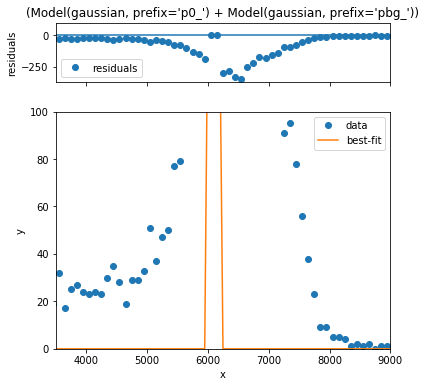

In [296]:
import scipy.ndimage as ndi
import scipy.signal as ss
import lmfit
from functools import reduce

def gethistfilt(images,gain=None,bg=0,**args):
    mask=maskdual
    for n,img in enumerate(images):
        
        if n%50==0 and n>0: print(n)
        if gain is not None:
            img=(img*gain*3.65)
        img=img-np.nan_to_num(bg)
     
        maxind=ndi.maximum_filter(img,3)==img
#         maxind[ss.convolve(maxind.astype(float),np.ones((5,5)),mode='same')>1]=False
        currentmask=np.logical_and(maxind,mask)
#         img=ss.convolve(img,np.ones((1,1)),mode='same')
        val,edge=np.histogram(img[currentmask],**args)
        yield val
        
allfound=[]
for i in range(100,4900,10):
    r=[500,30000]
    bins=(r[1]-r[0])/100
    x=np.linspace(*r,bins+1)+((r[1]-r[0])/bins)/2
    hist=(sum(gethistfilt(run.detector_2d_assembled_1[i:i+1],gain=run.detector_2d_assembled_1.absolute_gain,bg=bg,range=r,bins=int(bins+1))))
#     plt.plot(x,hist)
#     plt.xlim(r)
#     plt.show()
    
    
    
    

    bgmodel=None
    low=5000
    high=20000


    # bgmodel=(lmfit.models.LinearModel(prefix="l_"))
    # bgmodel.set_param_hint(f'slope', value=0,min=-1,max=1)
    # bgmodel.set_param_hint(f'intercept', value=0,min=-2000,max=2000)
    bgmodel=(lmfit.models.GaussianModel(prefix="pbg_"))
    bgmodel.set_param_hint(f'pbg_center', value=200,min=-200,max=+200,vary=False)
    bgmodel.set_param_hint(f'pbg_amplitude', value=1e5,min=0,max=1e9)
    bgmodel.set_param_hint(f'pbg_sigma', value=1000,min=0,max=2000)
    
    
    # params=(model.make_params()) 
    # for key in params.keys(): 
    #     params[key].vary=False

    peak=x[np.argmax(hist*(x>low)*(x<high))]
    low=np.argmax(x>low)
    high=np.argmax(x>high)

    centers=[peak]
    modelsp=([lmfit.models.GaussianModel(prefix=f'p{i}_') for i in range(len(centers))])
    for i in range(len(centers)): modelsp[i].set_param_hint(f'p{i}_center', value=centers[i],min=centers[i]-800,max=centers[i]+800)
    for i in range(len(centers)): modelsp[i].set_param_hint(f'p{i}_amplitude', value=1e5,min=0,max=1e8)
    for i in range(len(centers)): modelsp[i].set_param_hint(f'p{i}_sigma', value=1000,min=0,max=1500)

    # params=modelsp[0].make_params()
    # for i,m in enumerate(modelsp[1:]):
    #     params.update(m.make_params() )
    model = reduce((lambda x, y: x + y), modelsp) 
    if bgmodel is not None: model=model+bgmodel
    params=model.make_params()
    output = model.fit(hist, params, x=x)
#     output.plot()
    found=[(v) for n,v in enumerate([output.params[k].value for k in output.params.keys() if "center" in k])]
    print(found)
    if np.abs(found[0]-6400)>200:
        output.plot()

        plt.xlim((3500,9000))
        plt.ylim([0,100])
        plt.show()
        break
    print(found)
    allfound.append(found)
    # plt.xlim((3500,9000))